<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Reading original data

In [201]:
PATH_TO_DATA = ('../../data/alice/')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

Separate target feature 

In [202]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [203]:
sites = [f'site{i}' for i in range(1, 11)]
times = [f'time{i}' for i in range(1, 11)]

In [204]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')
train_df = train_df[train_df[times[0]] > pd.to_datetime('2013-11')]
y = train_df['target']
train_df.drop(['target'], axis='columns', inplace=True)

In [205]:
data = pd.concat([train_df, test_df], ignore_index=True)
data[times] = data[times].apply(pd.to_datetime)
data[sites] = data[sites].astype(str)


In [ ]:
max_time = data[times].max(axis=1)
max_time.shape
delta_time = (max_time - data[times[0]])
delta_time = delta_time.apply(lambda t: t.total_seconds())


In [ ]:
def per(t):
    if 0 <= t < 100:
        return 0
    if 100 <= t < 250:
        return 1
    if 250 <= t < 500:
        return 3
    if 500 <= t:
        return 4

delta_time = delta_time.apply(per)


In [ ]:
sns.countplot(delta_time[:train_df.shape[0]].as_matrix()[y == 1])

In [ ]:
delta_time = pd.get_dummies(delta_time, prefix='delta_time')

In [ ]:
delta_time.head()

In [ ]:
ss = StandardScaler()
delta_time = ss.fit_transform(delta_time.reshape(-1,1))

In [155]:

delta_time = pd.DataFrame(data=delta_time.tolist(), columns=['delta_time'])

In [15]:
train_df.shape, y.shape

((229931, 20), (229931,))

In [29]:
t = train_df[times[0]][y == 1]

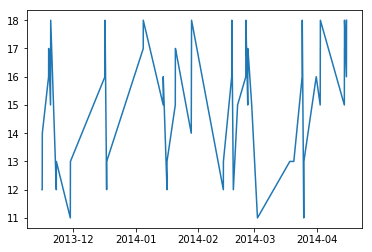

In [60]:
plt.plot(t, [_.hour for _ in t])

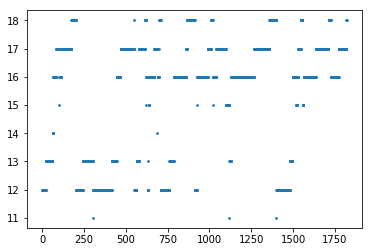

In [57]:
plt.scatter(list(range(t.shape[0])), [_.hour for _ in t], s=3)

In [ ]:
sns.countplot()

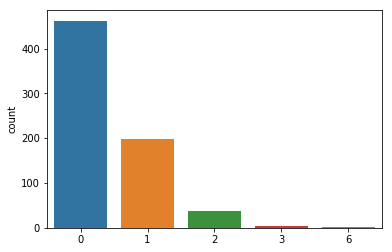

In [40]:
weekend_day = [_.weekday() for _ in t if _ > pd.to_datetime('2014-03')]
sns.countplot(weekend_day)

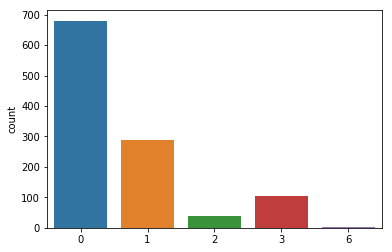

In [41]:
weekend_day = [_.weekday() for _ in t if _ > pd.to_datetime('2014-02')]
sns.countplot(weekend_day)

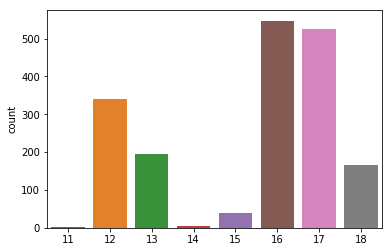

In [32]:
hours = [_.hour for _ in t]
sns.countplot(hours)

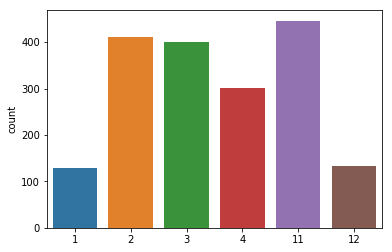

In [58]:
sns.countplot([_.month for _ in t ])

In [206]:
tfidf_data = data[sites].apply(lambda row: ' '.join(row), axis=1)

In [207]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=100000).fit(tfidf_data)
X_site_train = tfidf.transform(tfidf_data[:train_df.shape[0]])
X_site_test = tfidf.transform(tfidf_data[train_df.shape[0]:])

# Feature time #

1. onehotencode first date

2. Long time of session

3. Number of unique sites

4. Mean long time of session

5. Weekday

6. Part of day

In [208]:
#OneHotEncode
#first_year = data[times[0]].apply(lambda t: t.year)
#first_month = data[times[0]].apply(lambda t: t.month)
#first_day = data[times[0]].apply(lambda t: t.day)
first_hour = data[times[0]].apply(lambda t: t.hour)

In [209]:
time_features = pd.DataFrame()
#time_features['year'] = first_year
#time_features['month'] = first_month
# time_features['day'] = first_day
time_features['hour'] = first_hour

In [210]:
time_features = pd.get_dummies(time_features, columns=['hour'])

In [135]:
time_features.head()

,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
data[sites] = data[sites].astype(float)
data[sites] = data[sites].fillna(-1)
count_uniq_sites = pd.DataFrame(data=data[sites].apply(lambda row: np.unique(row[row > 0]).shape[0], axis=1).tolist(), 
                                columns=['count_uniq_sites'])
count_uniq_sites.head()

,count_uniq_sites
0,3
1,8
2,2
3,5
4,8


In [211]:
weekend = data[times[0]].apply(lambda t: t.date().weekday())
weekend_dummy = pd.get_dummies(weekend, prefix='weekday')
weekend_dummy.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [93]:
is_weekend = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if t.date().weekday() in (5, 6) else 0).tolist(), 
                          columns=['is_weekend'])
is_weekend.head()

,is_weekend
0,0
1,0
2,0
3,0
4,0


In [212]:

part_day = pd.DataFrame(data=data[times[0]].apply(lambda t: 0 if t.strftime('%p') == 'AM' else 1).tolist(), 
                        columns=['part_day'])

part_day.head()

,part_day
0,0
1,0
2,0
3,0
4,0


In [117]:
morning = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 0 < t.hour < 11 else 0).tolist(), 
                       columns=['morning'])
day = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 11 <= t.hour < 19 else 0).tolist(), 
                   columns=['day'])
evening = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 19 <= t.hour <= 0 else 0).tolist(), 
                       columns=['evening'])

In [88]:
work_time = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 10 < t.hour < 19 else 0).tolist(), 
                         columns=['work_time'])
evening_time = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 14 < t.hour < 19 else 0).tolist(), 
                         columns=['evening_time'])

In [213]:
part1 = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 6 <= t.hour <= 11 else 0).tolist(), 
                         columns=['part1'])
part2 = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 11 < t.hour <= 13 else 0).tolist(), 
                         columns=['part2'])
part3 = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 13 < t.hour < 16 else 0).tolist(), 
                         columns=['part3'])
part4 = pd.DataFrame(data=data[times[0]].apply(lambda t: 1 if 16 <= t.hour < 19 else 0).tolist(), 
                         columns=['part4'])


In [214]:
# generate_features = pd.concat([part_day, weekend_dummy, is_weekend, count_uniq_sites, time_features], axis='columns')
generate_features = pd.concat([weekend_dummy,
                               part_day, time_features,
                               part1, part2, part3,
                               part4], axis='columns')

In [215]:
generate_features.head()


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,part_day,hour_7,hour_8,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part1,part2,part3,part4
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [216]:
generate_features_train = generate_features.iloc[:train_df.shape[0], :]
generate_features_test = generate_features.iloc[train_df.shape[0]:, :]

In [217]:
X_train = hstack((csr_matrix(generate_features_train.as_matrix()), X_site_train))
X_test = hstack((csr_matrix(generate_features_test.as_matrix()), X_site_test))

In [36]:
X_train

<229931x100011 sparse matrix of type '<class 'numpy.float64'>'
	with 4123152 stored elements in COOrdinate format>

In [37]:
X_train.shape, X_test.shape

((229931, 100011), (82797, 100011))

In [218]:
lr = LogisticRegressionCV(Cs=10, 
                          class_weight='balanced', 
                          cv=TimeSeriesSplit(n_splits=5), 
                          max_iter=100,
                          scoring='roc_auc').fit(X_train, y)

In [223]:
lr.C_

array([ 2.7825594])

In [220]:
for coef, feat in zip(lr.coef_[0][:29], generate_features_train.columns[:29]):
    print(feat, coef)

weekday_0 1.74259350593
weekday_1 1.33483443791
weekday_2 -2.84669288671
weekday_3 -0.929526192216
weekday_4 0.509338058394
weekday_5 0.257128330546
weekday_6 -0.45317133504
part_day 1.52049309137
hour_7 -0.0366515031035
hour_8 -1.89353480945
hour_9 -1.99127166355
hour_10 -2.08039541926
hour_11 4.09586422281
hour_12 1.58683821833
hour_13 1.45057842353
hour_14 -0.548367819866
hour_15 1.51418744626
hour_16 0.829423629949
hour_17 1.52703113116
hour_18 1.86593469152
hour_19 -1.58829877986
hour_20 -0.862606396547
hour_21 -1.76966824516
hour_22 -1.42719066051
hour_23 -1.05736854744
part1 -1.90598917256
part2 3.03741664186
part3 0.965819626395
part4 4.22238945263


In [221]:
lr.scores_[1]

array([[ 0.80470664,  0.89275517,  0.91181546,  0.91058839,  0.907151  ,
         0.90552568,  0.90153485,  0.8908494 ,  0.87659092,  0.86477427],
       [ 0.86875199,  0.87286244,  0.87726217,  0.89773967,  0.91660236,
         0.92193098,  0.91991186,  0.91269796,  0.91933465,  0.92214115],
       [ 0.90050696,  0.90282007,  0.92918353,  0.94946231,  0.96042555,
         0.96491014,  0.9644118 ,  0.9633009 ,  0.95202749,  0.95396035],
       [ 0.95620375,  0.95485791,  0.96066921,  0.96862607,  0.96992088,
         0.96865383,  0.96638439,  0.96222672,  0.9529048 ,  0.95104236],
       [ 0.93187892,  0.92670576,  0.93271265,  0.94033492,  0.94733531,
         0.95124213,  0.9333489 ,  0.91945908,  0.91324238,  0.91426683]])

In [222]:
lr.scores_[1][-1].mean()

0.93105268707048672

In [39]:
pred = lr.predict_proba(X_test)
# pred[pred < 0.001] = 0.001
# pred[pred > 0.999] = 0.999

In [40]:
pd.DataFrame({'session_id': test_df.index, 'target': pred[:, 1]}).to_csv('sub.csv', index=False)

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [ ]:
# You code here

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [ ]:
# You code here

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [ ]:
# You code here

Perform cross-validation with logistic regression.

In [ ]:
# You code here

Make prediction for the test set and form a submission file.

In [ ]:
test_pred = # You code here

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [ ]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")